In [5]:
from img_doc.dataset import PubLayNetDataset
from img_doc.document import Document

from img_doc.document import Document, Block
from img_doc.document.page.extractors.block_extractors import PageAndWordClassificator, BaseRandomWalkClassificator, BaseRandomDeepNodeClassificator

import numpy as np
import json
import random

import tensorflow as tf
import keras
from keras import layers

tf.random.set_seed(22)

import pandas as pd
from time import time
import matplotlib.pyplot as plt
import os

In [6]:
pln_ds = PubLayNetDataset(r"/home/daniil/program/dataset/publaynet/", 
                          r"/home/daniil/program/dataset/tmp_publaynet/")

In [10]:
def shuffle(x_arrays, y_arrays):
    x_vec = np.concatenate(x_arrays)
    y_vec = np.concatenate(y_arrays)
    data = [(x, y) for x, y in zip(x_vec, y_vec)]
    random.shuffle(data)
    x_vec_rnd = np.array([x for x, y in data])
    y_vec_rnd = np.array([y for x, y in data])
    return x_vec_rnd, y_vec_rnd
    

def get_data(dataset, balans=True): #, batch_size=128

    X = np.array(dataset["x"])
    y = np.array(dataset["y"])
    
    keys = np.unique(y)
    Y_keys = dict()
    for i, key in enumerate(keys):
        z = np.zeros(5)
        z[i] = 1
        Y_keys[key] = z
    Y = np.array([Y_keys[yi] for yi in y])

    X_clus_list = []
    Y_clus_list = []

    for i, item in enumerate(Y_keys.keys()):
        X_clus_list.append(X[Y[:,i]==1,:])
        Y_clus_list.append(Y[Y[:,i]==1,:])
        
    if balans:
        balans_len = [len(yc) for yc in Y_clus_list]
        min_len = min(balans_len)
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    val_x = []
    val_y = []
    for class_data in zip(X_clus_list, Y_clus_list):
        data = [(x, y) for x, y in zip(class_data[0], class_data[1])]
        random.shuffle(data)
        if balans:
            data = data[:min_len]
        len_data = len(data)
        len_test = round(0.2*len_data)
        len_val = round((len_data-len_test)*0.2)
        len_train = len_data - len_test - len_val
        
        train_x.append([x for x, y in data[:len_train]])
        train_y.append([y for x, y in data[:len_train]])
        
        val_x.append([x for x, y in data[len_train:len_train+len_val]])
        val_y.append([y for x, y in data[len_train:len_train+len_val]])
    
        test_x.append([x for x, y in data[-len_test:]])
        test_y.append([y for x, y in data[-len_test:]])
        
    train_x, train_y = shuffle(train_x, train_y)
    val_x, val_y = shuffle(val_x, val_y)
    test_x, test_y = shuffle(test_x, test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y, Y_keys

def get_dataset(pwc, name, set_):
    def fun_from_tmp_and_path_image(tmp_json, img_path):
        doc = Document()
        doc.set_from_path(img_path)
        doc.pages[0].set_blocks_from_dict(tmp_json["blocks"])
        doc.pages[0].set_words_from_dict(tmp_json["additional_info"]["words"])
        if "bold" in set_:
            doc.pages[0].extract_word_bold()
        for word in doc.pages[0].words:
            for block in doc.pages[0].blocks:
                if block.segment.is_intersection(word.segment):
                    block.words.append(word)
        x = []
        y = []
        for page in doc.pages:
            try:
                x =pwc.get_block_and_page_vecs(page)
                for block in page.blocks:
                    y.append(block.label)
            except:
                print(doc.path)
        return {"x": x, "y": y}
    
    rez = pln_ds.get_json_from_tmps_and_images(fun_from_tmp_and_path_image, balans = True)
    
    dataset = {"x": [], "y": []}
    for train_i in rez["train"]:
        for x in train_i["x"]:
            dataset["x"].append(x)
        for y in train_i["y"]:
            dataset["y"].append(y)

    train_x, train_y, val_x, val_y, test_x, test_y, Y_keys = get_data(dataset, balans=True)

    with open(name, "w") as f:
        json.dump({"train_x": train_x.tolist(), "train_y": train_y.tolist(),
                   "val_x": val_x.tolist(), "val_y": val_y.tolist(), 
                   "test_x": test_x.tolist(), "test_y": test_y.tolist()}, f)

In [ ]:
brwc = BaseRandomWalkClassificator(conf={"properties": ["many_dist", "many_angle", "place_in_block", "height", "bold"],
                                         "count_step":100})
brdc = BaseRandomDeepNodeClassificator({"properties":["many_dist", "many_angle", "place_in_block", "height", "bold"],
                                        "count_node":5, 
                                        "deep":3 })
pwc = PageAndWordClassificator(brdc, conf={"properties":["place_in_page", "count_word_in_page"]})

get_dataset(pwc, name="dataset_2.json", set_=["bold"])

train:
/home/daniil/program/dataset/publaynet/train/PMC3505796_00004.jpg
/home/daniil/program/dataset/publaynet/train/PMC5329893_00002.jpg


/home/daniil/program/python/project/layout_highlighter/imgDoc/env/lib/python3.10/site-packages/img_doc/document/page/extractors/word_extractors/bold_extractors/sph_bold_extractor.py:46: RuntimeWarning: Mean of empty slice.
  mean_ = img_word.mean(1)
/home/daniil/program/python/project/layout_highlighter/imgDoc/env/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


/home/daniil/program/dataset/publaynet/train/PMC5919984_00000.jpg
/home/daniil/program/dataset/publaynet/train/PMC5800348_00000.jpg
/home/daniil/program/dataset/publaynet/train/PMC5397437_00004.jpg
/home/daniil/program/dataset/publaynet/train/PMC4782684_00238.jpg
/home/daniil/program/dataset/publaynet/train/PMC6087436_00004.jpg
/home/daniil/program/dataset/publaynet/train/PMC4233714_00005.jpg
/home/daniil/program/dataset/publaynet/train/PMC4781946_00002.jpg
/home/daniil/program/dataset/publaynet/train/PMC3644173_00007.jpg
/home/daniil/program/dataset/publaynet/train/PMC5004597_00008.jpg
/home/daniil/program/dataset/publaynet/train/PMC3993045_00000.jpg
/home/daniil/program/dataset/publaynet/train/PMC5029444_00005.jpg
/home/daniil/program/dataset/publaynet/train/PMC4867865_00005.jpg
/home/daniil/program/dataset/publaynet/train/PMC6055857_00003.jpg
/home/daniil/program/dataset/publaynet/train/PMC5773900_00006.jpg
/home/daniil/program/dataset/publaynet/train/PMC5703426_00026.jpg
/home/dani

In [3]:
name_model = "RWMDMAPHB-PLN"
with open("dataset_1.json", "r") as f:
    dataset = json.load(f)

In [4]:
print("Первый x:\n", dataset["train_x"][0])
print("Последний, x:\n", dataset["train_x"][-1])
x_len = len(dataset["train_x"][0])
print("Размер x:\t", x_len)
print("Первый y:\t", dataset["train_y"][0])
print("Последний y:\t", dataset["train_y"][0])
print("Кол-во записей:\t", len(dataset["train_x"]))

Первый x:
 [0.09433962264150944, 0.08770580193070292, 0.1320754716981132, 0.11858541225631422, 0.3980923368397325, 1.0, 0.32436597193815186, 1.0, 0.12195121951219513, 0.5234657039711191, 0.5833333333333334, 1.0, 0.1320754716981132, 0.08770580193070292, 0.03773584905660377, 1.0, 0.32436597193815186, 0.9908301680442989, 0.5112789843479856, 0.0, 0.058536585365853655, 0.5740072202166064, 0.6666666666666667, 0.40296052631578944, 0.03773584905660377, 0.11694106924093722, 0.09433962264150944, 0.65431261641512, 0.5112789843479856, 0.9931506043228762, 0.5629875818355481, 0.0, 0.06341463414634146, 0.6101083032490975, 0.5833333333333334, 0.8270676691729322, 0.03773584905660377, 0.11694106924093722, 0.09433962264150944, 0.65431261641512, 0.5112789843479856, 0.9931506043228762, 0.5629875818355481, 0.0, 0.06341463414634146, 0.6101083032490975, 0.5833333333333334, 0.8270676691729322, 0.1320754716981132, 0.08770580193070292, 0.03773584905660377, 1.0, 0.32436597193815186, 0.9908301680442989, 0.51127898

In [49]:
# train_x, train_y, val_x, val_y, test_x, test_y, = dataset["train_x"], dataset["train_y"], dataset["val_x"], dataset["val_y"], dataset["test_x"] , dataset["test_y"]
# train_x = np.array([np.concatenate([x[:24], x[-3:]]) for x in train_x])
# val_x =  np.array([np.concatenate([x[:24], x[-3:]]) for x in val_x])
# val_y = np.array(val_y)
# train_y = np.array(train_y)
# test_x = np.array([np.concatenate([x[:24], x[-3:]]) for x in test_x])
# test_y = np.array(test_y)
# #batch 75 (ac:65) node 40 в конце лучше не ставить большой dropout, а перед 0.2
# mega_hist = []
# # for arg in args:
# hist = []
# model = keras.Sequential()

# input_len = len(train_x[0])
# output_len = 5

# model.add(layers.Dense(units=input_len, activation='relu'))
# model.add(layers.Dropout(rate=0.2, seed=22))
# model.add(layers.Dense(units=40,  activation='relu'))
# # model.add(layers.Dropout(rate=arg[1], seed=22))
# model.add(layers.Dense(units=output_len, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

  
history = model.fit(train_x, train_y, epochs=30, batch_size=75, validation_data=(val_x, val_y))
hist.append(history)

loss_and_metrics = model.evaluate(test_x, test_y, batch_size=75)
loss_and_metrics
mega_hist.append({"hist": hist, "loss_and_metrics": loss_and_metrics})

Epoch 1/30
280/280 [==============================] - 0s 1ms/step - loss: 0.7623 - accuracy: 0.6780 - val_loss: 0.7645 - val_accuracy: 0.6786
Epoch 2/30
280/280 [==============================] - 0s 1ms/step - loss: 0.7624 - accuracy: 0.6753 - val_loss: 0.7618 - val_accuracy: 0.6801
Epoch 3/30
280/280 [==============================] - 0s 1ms/step - loss: 0.7586 - accuracy: 0.6810 - val_loss: 0.7560 - val_accuracy: 0.6768
Epoch 4/30
280/280 [==============================] - 0s 1ms/step - loss: 0.7594 - accuracy: 0.6742 - val_loss: 0.7485 - val_accuracy: 0.6810
Epoch 5/30
280/280 [==============================] - 0s 1ms/step - loss: 0.7560 - accuracy: 0.6829 - val_loss: 0.7531 - val_accuracy: 0.6833
Epoch 6/30
280/280 [==============================] - 0s 1ms/step - loss: 0.7603 - accuracy: 0.6787 - val_loss: 0.7510 - val_accuracy: 0.6816
Epoch 7/30
280/280 [==============================] - 0s 1ms/step - loss: 0.7618 - accuracy: 0.6763 - val_loss: 0.7480 - val_accuracy: 0.6833
Epoch 

In [24]:
# with open("batchs.json", "w") as f:
#         json.dump({"args": args,
#                    "mega_hist":mega_hist}, f)

ValueError: x and y must have same first dimension, but have shapes (5,) and (11,)

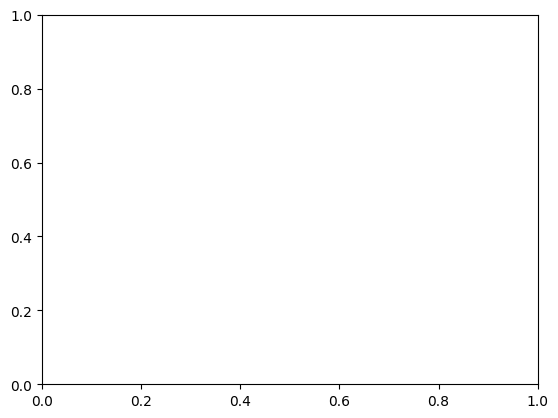

In [50]:
bch = [a for a in args]
test_metr = [m["loss_and_metrics"][1] for m in mega_hist]

plt.plot(bch, test_metr, '.:')
# plt.plot(bch[1::3], test_metr[1::3], '.')
# plt.plot(bch[2::3], test_metr[2::3], '.')
plt.ylim([0.6, 0.8])
plt.title("accuracy от dropout")

In [13]:
args[np.argmin(test_metr)]

[0.2, 0.8]

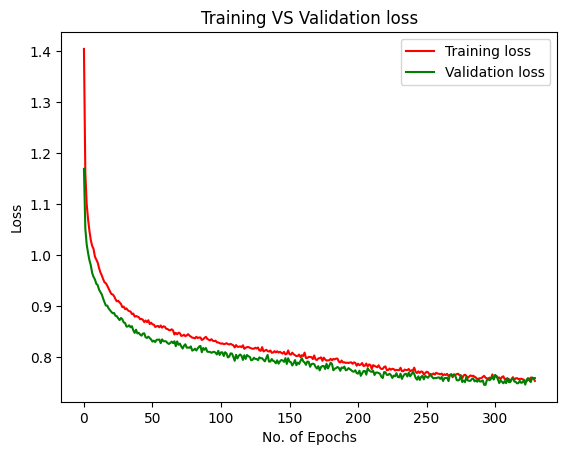

In [51]:
plt.plot(np.concatenate([h.history['loss'] for h in mega_hist[-1]["hist"]]), 'r', label='Training loss')
plt.plot(np.concatenate([h.history['val_loss'] for h in  mega_hist[-1]["hist"]]), 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

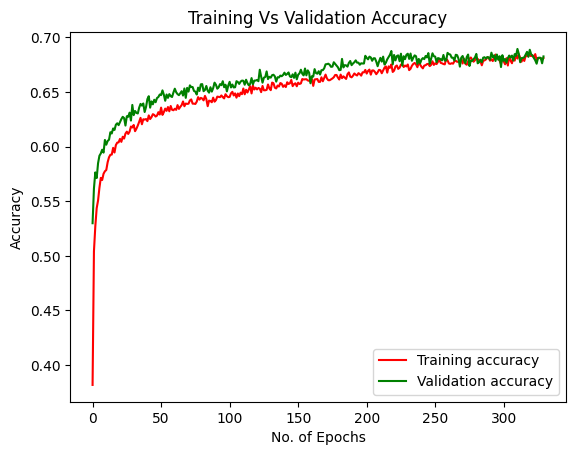

In [52]:
plt.plot(np.concatenate([h.history['accuracy'] for h in mega_hist[-1]["hist"]]), 'r', label='Training accuracy')
plt.plot(np.concatenate([h.history['val_accuracy'] for h in mega_hist[-1]["hist"]]), 'g', label='Validation accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, input_len], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    print(y)
    y = self.class_pred(y)
    return y

def preprocess_test(x):
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return y

In [54]:
mlp_model_export = ExportModule(model=model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [55]:
save_path = name_model
tf.saved_model.save(mlp_model_export, save_path)
mlp_loaded = tf.saved_model.load(save_path)

Tensor("sequential_11/dense_35/Softmax:0", shape=(None, 5), dtype=float32)
INFO:tensorflow:Assets written to: RWMDMAPHB-PLN/assets


INFO:tensorflow:Assets written to: RWMDMAPHB-PLN/assets


In [56]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

test_classes = mlp_loaded(test_x)
test_acc = accuracy_score([np.argmax(y) for y in test_classes], [np.argmax(y) for y in test_y])
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.678
